In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.covariance
import sklearn.cluster
import datetime
import fastdtw

In [3]:
met = pd.read_hdf('../../input/df/met/usa_ds3505.h5').loc[724050]

In [4]:
obs = pd.read_hdf('../../input/df/obs/cherry_dc.h5').loc['DC']

In [5]:
#years = list(range(1940, 2010))
years = list(set(range(1940, 2010)) - set([1946, 1970, 1971, 1972, 1973]))

In [6]:
L = 5000

In [7]:
def timeseries(year, length=L, s=met.tavg):
    t = datetime.date(year-1, 10, 1)
    return np.array(s.loc[t:][:length])

In [8]:
def timeseriess(years, length=L, s=met.tavg):
    return np.array([timeseries(y, length, s) for y in years])

In [9]:
def timeframe(year, length=L, s=met.tavg, freq='D', to_dict=False):
    t = datetime.date(year-1, 10, 1)
    hows = ['mean', 'min', 'max']
    a = s.loc[t:][:length].resample(freq).aggregate(hows).values
    if to_dict:
         return dict(zip(hows, a.T))
    else:
         return a

In [10]:
def timeframes(years, length=L, s=met.tavg, freq='D'):
    return np.array([timeframe(y, length, s, freq).flatten() for y in years])

In [11]:
def time_winter_months(year, s=met.tavg):
    t0 = datetime.date(year-1, 12, 1)
    t1 = datetime.date(year, 3, 31)
    hows = ['mean', 'min', 'max']
    return s.loc[t0:][:t1].resample('M').aggregate(hows).values

In [12]:
time_winter_months(2010)

array([[ 3.31352723, -4.4       , 17.8       ],
       [ 1.51061922, -8.9       , 19.4       ],
       [ 1.28952771, -8.3       , 10.        ],
       [10.38751318,  0.6       , 23.67333333]])

In [13]:
time_winter_months(2000)

array([[ 5.47701207, -6.1       , 19.85      ],
       [ 1.92732976, -9.4       , 21.1       ],
       [ 5.24952345, -5.36      , 22.71      ],
       [10.84508735, -2.68      , 28.985     ]])

In [14]:
def plot_heatmap(M):
    mask = np.zeros_like(M, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(M, mask=mask, vmax=np.ma.array(M, mask=mask).max(), vmin=M.min())

In [15]:
def affinity_matrix_hourly(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = timeseries(yi, length, s)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeseries(yj, length, s)
                d = fastdtw.fastdtw(ai, aj, radius=1)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [16]:
#plot_heatmap(affinity_matrix_hourly(years))

In [17]:
def affinity_matrix_daily(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = timeframe(yi, length, s)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeframe(yj, length, s)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [18]:
#plot_heatmap(affinity_matrix_daily(years))

In [19]:
def affinity_matrix_daily_mean(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = timeframe(yi, length, s, to_dict=True)['mean']
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeframe(yj, length, s, to_dict=True)['mean']
                d = fastdtw.fastdtw(ai, aj, radius=1)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [20]:
#plot_heatmap(affinity_matrix_daily_mean(years))

In [21]:
def affinity_matrix_daily_diff(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    for (i, yi) in enumerate(years):
        ai = timeframe(yi, length, s, to_dict=True)['mean'] - am
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeframe(yj, length, s, to_dict=True)['mean'] - am
                d = fastdtw.fastdtw(ai, aj, radius=1)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [22]:
#plot_heatmap(affinity_matrix_daily_diff(years))

In [23]:
def affinity_matrix_daily_cumulative_residual(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    def a(y):
        ad = timeframe(y, length, s, to_dict=True)['mean'] - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for (i, yi) in enumerate(years):
        ai = a(yi)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = a(yj)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [24]:
#plot_heatmap(affinity_matrix_daily_cumulative_residual(years))

In [25]:
def affinity_matrix_daily_cumulative_diff(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    def a(y):
        tf = timeframe(y, length, s, to_dict=True)['mean']
        ad = tf[:-1] - tf[1:]
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for (i, yi) in enumerate(years):
        ai = a(yi)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = a(yj)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [26]:
#plot_heatmap(affinity_matrix_daily_cumulative_diff(years))

In [27]:
def affinity_matrix_hourly_cumulative_residual(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    am = np.array([timeseries(y, length, s) for y in years]).mean(axis=0)
    def a(y):
        ad = timeseries(y, length, s) - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for (i, yi) in enumerate(years):
        ai = a(yi)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = a(yj)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [28]:
#plot_heatmap(affinity_matrix_hourly_cumulative_residual(years))

In [29]:
def covariance_matrix(years, length=L, s=met.tavg):
    X = np.array([timeseries(y, length, s) for y in years])
    cov = sklearn.covariance.GraphLassoCV()
    cov.fit(X.T)
    return cov.covariance_

In [30]:
#plot_heatmap(covariance_matrix(years))

In [31]:
def correlation_matrix(years, length=L, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = pd.Series(timeseries(yi, length, s))
        for (j, yj) in enumerate(years):
            aj = pd.Series(timeseries(yj, length, s))
            M[i, j] = M[j, i] = ai.corr(aj)
    return M

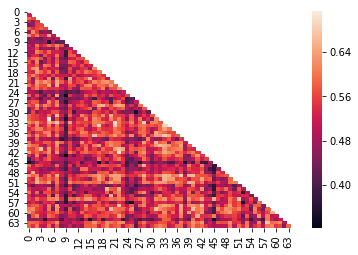

In [32]:
plot_heatmap(correlation_matrix(years))

In [33]:
def timefeature(year, length=L, s=met.tavg, to_dict=False):
    t = datetime.date(year-1, 10, 1)
    df = s.loc[t:][:length]
    def feature(h):
        v = df.resample('M').aggregate(h).tolist()
        if to_dict:
            k = ['t{}{}'.format(h, i) for i in range(len(v))]
            return dict(zip(k, v))
        else:
            return v
    fs = [feature(h) for h in {'mean', 'min', 'max'}]
    if to_dict:
        d = {}
        [d.update(f) for f in fs]
        return d
    else:
        return sum(fs, [])

In [34]:
def affinity_matrix_feature(years, length=L, s=met.tavg):
    X = np.array([timefeature(y) for y in years])
    return sklearn.metrics.pairwise_distances(X)

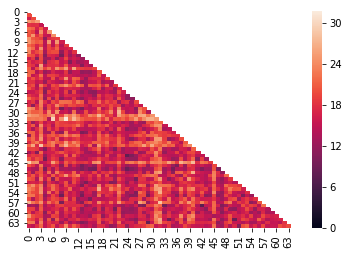

In [35]:
plot_heatmap(affinity_matrix_feature(years))

In [36]:
import scipy.signal

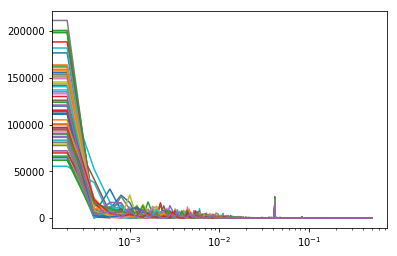

In [37]:
for y in years:
    plt.semilogx(*scipy.signal.periodogram(timeseries(y)))

In [38]:
#M = affinity_matrix_daily(years)
#M = affinity_matrix_hourly(years)
M = correlation_matrix(years)
af = sklearn.cluster.AffinityPropagation(affinity='precomputed').fit(M)

In [39]:
groups = np.unique(af.labels_)
groups

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [40]:
mask = np.zeros_like(M, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [41]:
np.ma.array(M, mask=mask).max()

0.7151137417981396

In [42]:
M.min()

0.32242378704776636

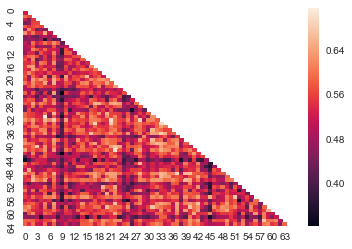

In [43]:
sns.set(style='white')
#sns.heatmap(M, mask=mask, vmax=np.ma.array(M, mask=mask).max(), vmin=M.min())
plot_heatmap(M)

In [44]:
DM = 1/M
np.fill_diagonal(DM, 0)
D = scipy.spatial.distance.squareform(DM)

{'icoord': [[105.0, 105.0, 115.0, 115.0],
  [185.0, 185.0, 195.0, 195.0],
  [315.0, 315.0, 325.0, 325.0],
  [345.0, 345.0, 355.0, 355.0],
  [385.0, 385.0, 395.0, 395.0],
  [375.0, 375.0, 390.0, 390.0],
  [365.0, 365.0, 382.5, 382.5],
  [350.0, 350.0, 373.75, 373.75],
  [455.0, 455.0, 465.0, 465.0],
  [495.0, 495.0, 505.0, 505.0],
  [545.0, 545.0, 555.0, 555.0],
  [535.0, 535.0, 550.0, 550.0],
  [525.0, 525.0, 542.5, 542.5],
  [515.0, 515.0, 533.75, 533.75],
  [500.0, 500.0, 524.375, 524.375],
  [485.0, 485.0, 512.1875, 512.1875],
  [475.0, 475.0, 498.59375, 498.59375],
  [595.0, 595.0, 605.0, 605.0],
  [585.0, 585.0, 600.0, 600.0],
  [575.0, 575.0, 592.5, 592.5],
  [565.0, 565.0, 583.75, 583.75],
  [486.796875, 486.796875, 574.375, 574.375],
  [460.0, 460.0, 530.5859375, 530.5859375],
  [635.0, 635.0, 645.0, 645.0],
  [625.0, 625.0, 640.0, 640.0],
  [615.0, 615.0, 632.5, 632.5],
  [495.29296875, 495.29296875, 623.75, 623.75],
  [445.0, 445.0, 559.521484375, 559.521484375],
  [435.0, 43

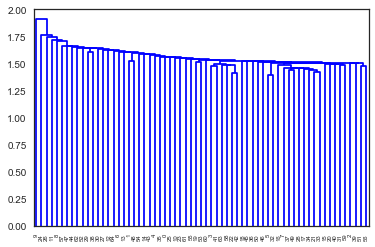

In [45]:
Z = scipy.cluster.hierarchy.linkage(D)
scipy.cluster.hierarchy.dendrogram(Z)

In [46]:
def plot_group_hourly(af, years, group):
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            print(y)
            pd.Series(timeseries(y)).plot(figsize=(4,3), ylim=(-25, 35))

In [47]:
def plot_group_daily(af, years, group):
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            print(y)
            pd.DataFrame(timeframe(y, to_dict=True)).plot(figsize=(4,3), ylim=(-25, 35))

In [48]:
def plot_group_daily_cumulative_residual(af, years, group, length=L, s=met.tavg):
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    def a(y):
        ad = timeframe(y, length, s, to_dict=True)['mean'] - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            print(y)
            ai = a(y).T
            plt.figure(figsize=(10,1))
            plt.subplot(1, 2, 1)
            pd.Series(ai[0]).plot(ylim=(0,500))
            plt.subplot(1, 2, 2)
            pd.Series(ai[1]).plot(ylim=(-500,0))

In [49]:
def plot_group_daily_cumulative_residual(af, years, group, length=L, s=met.tavg):
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    def a(y):
        ad = timeframe(y, length, s, to_dict=True)['mean'] - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T    
    plt.figure(figsize=(10,1))
    plt.subplot(1, 2, 1)
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            ai = a(y).T
            pd.Series(ai[0]).plot(ylim=(0,500))
    plt.subplot(1, 2, 2)
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            pd.Series(ai[1]).plot(ylim=(-500,0))

In [50]:
M

array([[1.        , 0.52191413, 0.59677404, ..., 0.4697523 , 0.58653665,
        0.58454756],
       [0.52191413, 1.        , 0.56398793, ..., 0.45558984, 0.58670246,
        0.54078125],
       [0.59677404, 0.56398793, 1.        , ..., 0.46198358, 0.58125064,
        0.59921083],
       ...,
       [0.4697523 , 0.45558984, 0.46198358, ..., 1.        , 0.4962045 ,
        0.45621254],
       [0.58653665, 0.58670246, 0.58125064, ..., 0.4962045 , 1.        ,
        0.58910247],
       [0.58454756, 0.54078125, 0.59921083, ..., 0.45621254, 0.58910247,
        1.        ]])

1941
1947
1960
1993


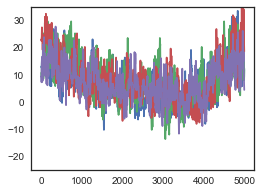

In [51]:
plt.figure()
plot_group_hourly(af, years, 0)

1950


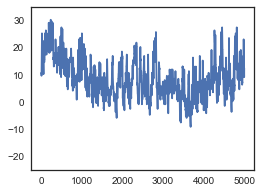

In [52]:
plt.figure()
plot_group_hourly(af, years, 1)

In [53]:
#plot_group_daily(af, years, 0)

In [54]:
npm = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2)

In [55]:
embedding = npm.fit_transform(timeseriess(years)).T
#embedding = npm.fit_transform(timeframes(years)).T

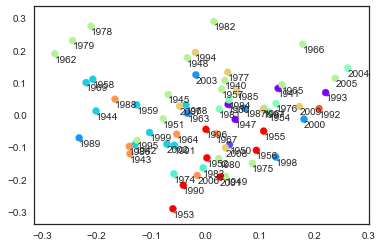

In [56]:
plt.scatter(embedding[0], embedding[1], c=af.labels_, cmap=plt.cm.rainbow)
for (i, (x, y)) in enumerate(zip(*embedding)):
    plt.text(x, y - 0.025, '{}'.format(years[i]), size='small')

In [57]:
df = pd.DataFrame(years, af.labels_)

In [58]:
#df.reset_index().sort_values(['index', 0]).set_index(['index'])

In [59]:
def extract_years(af, years, group):
    df = pd.DataFrame(years, af.labels_)
    return df[df.index == group][0].tolist()

In [60]:
extract_years(af, years, 0)

[1941, 1947, 1960, 1993]

In [61]:
{g: extract_years(af, years, g) for g in groups}

{0: [1941, 1947, 1960, 1993],
 1: [1950],
 2: [1963, 1987, 1989, 1998, 2000, 2003],
 3: [1942, 1944, 1958, 1959, 1968, 1969, 1991, 1999, 2002],
 4: [1974, 1983],
 5: [1954, 1961, 1976, 1981, 1984, 2004],
 6: [1940,
  1945,
  1948,
  1949,
  1951,
  1957,
  1962,
  1965,
  1966,
  1975,
  1978,
  1979,
  1980,
  1982,
  1995,
  2005],
 7: [1977, 1985, 1994, 1997, 2007, 2008, 2009],
 8: [1943, 1964, 1967, 1986, 1988, 2006],
 9: [1992],
 10: [1952, 1953, 1955, 1956, 1990, 1996, 2001]}

Group 8 includes the years of top 6 (1996), 7 (1983), 8 (2009), and 9 (2003) snowstorms in Washington, D.C.
Reference: http://www.wusa9.com/story/weather/2016/01/21/these-top-10-snowfalls-dc-history/79120848/

In [62]:
def extract_stat(af, years, group):
    v = np.array([timeseries(y) for y in extract_years(af, years, group)])
    return {
        'mean': v.mean(axis=1).mean(),
        'min': v.min(axis=1).min(),
        'max': v.max(axis=1).max(),
    }

In [63]:
{g: extract_stat(af, years, g) for g in groups}

{0: {'mean': 7.480868928571429, 'min': -13.7, 'max': 34.6},
 1: {'mean': 8.596739999999999, 'min': -9.2, 'max': 30.2},
 2: {'mean': 7.631235171104174, 'min': -15.9, 'max': 32.4},
 3: {'mean': 8.079875486973945, 'min': -15.3, 'max': 35.6},
 4: {'mean': 9.12121949832776, 'min': -8.2, 'max': 30.0},
 5: {'mean': 8.20269802692829, 'min': -17.1, 'max': 35.0},
 6: {'mean': 7.74003686682157, 'min': -20.5, 'max': 34.1},
 7: {'mean': 7.893644201690622, 'min': -20.0, 'max': 33.3},
 8: {'mean': 7.722629590394159, 'min': -16.7, 'max': 31.3},
 9: {'mean': 8.1565, 'min': -9.9, 'max': 29.4},
 10: {'mean': 7.615222651376833, 'min': -15.0, 'max': 34.1}}

In [64]:
def affinity_daily(af, years, year, group, length=L, s=met.tavg):
    years_group = extract_years(af, years, group)
    n = len(years_group)
    ai = timeframe(year, length, s)
    M = np.zeros(n)
    for (j, yj) in enumerate(years_group):
        aj = timeframe(yj, length, s)
        d = fastdtw.fastdtw(ai, aj, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
        M[j] = d
    return M

In [65]:
def predict_group_daily(af, years, year, length=L, s=met.tavg):
    r = np.array([affinity_daily(af, years, year, g).mean() for g in groups])
    ir = 1/r
    return (r.argmin(), ir/ir.sum())

In [66]:
%pdb

Automatic pdb calling has been turned ON


In [67]:
predict_group_daily(af, years, 2015)

(9, array([0.0904048 , 0.08523026, 0.09402089, 0.09138679, 0.08665836,
        0.09383751, 0.09052006, 0.09220162, 0.0912896 , 0.09741233,
        0.08703779]))

In [68]:
predict_group_daily(af, years, 2014)

(9, array([0.08950051, 0.08587332, 0.09413777, 0.09052797, 0.09134112,
        0.08950838, 0.0906412 , 0.09388554, 0.090348  , 0.09442235,
        0.08981384]))

In [69]:
predict_group_daily(af, years, 2013)

(9, array([0.0902699 , 0.0875666 , 0.0941485 , 0.09254659, 0.08985654,
        0.08897789, 0.09134282, 0.08774438, 0.08948207, 0.10046173,
        0.08760299]))

In [70]:
predict_group_daily(af, years, 2012)

(4, array([0.0899359 , 0.08671426, 0.09291814, 0.09205117, 0.09627215,
        0.09057462, 0.09073396, 0.09338483, 0.08918651, 0.09098949,
        0.08723896]))

In [71]:
predict_group_daily(af, years, 2011)

(5, array([0.09011513, 0.07544881, 0.09183004, 0.09203252, 0.09379376,
        0.0982347 , 0.09349478, 0.09106441, 0.08970699, 0.08858258,
        0.09569628]))

In [72]:
predict_group_daily(af, years, 2010)

(2, array([0.09644305, 0.07564868, 0.09765058, 0.09700065, 0.09122497,
        0.09207196, 0.09531905, 0.0913158 , 0.09087248, 0.08499475,
        0.08745802]))

In [73]:
[affinity_daily(af, years, 2011, g).mean() for g in groups]

[1347.1672486481962,
 1609.040061828432,
 1322.009111598746,
 1319.100648480629,
 1294.3308491132047,
 1235.8174324444146,
 1298.4698160639055,
 1333.1240620075903,
 1353.296474729385,
 1370.4742964236764,
 1268.598449982444]